In [1]:
import os
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.spatial import distance
from scipy.spatial import KDTree
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import scanpy as sc
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [2]:
def FindNeighbours(st_loc_df):
    st_loc_df = st_loc_df.iloc[:,0:2]
    dist_mat = distance.pdist(st_loc_df, "euclidean")
    dist_min = np.quantile(dist_mat, q = st_loc_df.shape[0]/len(dist_mat))
    kd_tree = KDTree(st_loc_df)
    neighbour_list = kd_tree.query_ball_tree(kd_tree, r = dist_min)
    neighbour_dict = {}
    for i in range(len(neighbour_list)):
        neighbour_list[i].remove(i)
        neighbour_dict[st_loc_df.index[i]] = st_loc_df.index[neighbour_list[i]]
    return(neighbour_dict)


def NeighbourAvgFrac(st_deconv_df, neighbour_dict):
    st_df = pd.DataFrame({'Spot':st_deconv_df.index}, index = st_deconv_df.index)
    neighbour_frac_df = st_df.apply(lambda x: st_deconv_df.loc[neighbour_dict[x[0]], ].mean(), axis=1)
    # print(neighbour_frac_df.isnull().T.any())
    neighbour_frac_df[neighbour_frac_df.isnull().T.any()] = st_deconv_df[neighbour_frac_df.isnull().T.any()]
    return(neighbour_frac_df)


def Clustering(deconv_res_file, st_loc_file,  n_clusters = 7, weight=0.5):
    st_deconv_df = deconv_res_file
    st_loc_df = st_loc_file

    neighbour_dict = FindNeighbours(st_loc_df)
    neighbour_frac_df = NeighbourAvgFrac(st_deconv_df, neighbour_dict)
    combined_frac_df = pd.concat([weight*st_deconv_df, (1-weight)*neighbour_frac_df], axis=1)

    kmeans_res = KMeans(n_clusters = n_clusters, random_state = 0, max_iter = 1000).fit(combined_frac_df)
    st_deconv_df["Cluster"] = kmeans_res.labels_
    st_loc_df["Cluster"] = st_deconv_df.loc[st_loc_df.index, "Cluster"]
    # st_cluster_df = st_loc_df["Cluster"]
    return st_loc_df

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


0.46603159796911203
0.6215245956010964


... storing 'feature_types' as categorical
... storing 'genome' as categorical


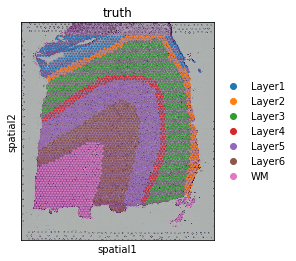

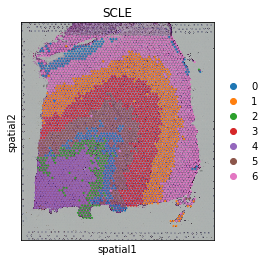

In [3]:
scle_pred = pd.read_csv('D:/lhj/study/Code/SCLE-decon/data/DLPFC/151673/SCLE_predict_A.csv', header=0, index_col=0)
scle_pred.columns = [s.replace('/', '_') for s in scle_pred.columns]
st = sc.read_visium('D:/lhj/study/Code/SCLE-master/data/DLPFC/151673', count_file='filtered_feature_bc_matrix.h5')
metadata = pd.read_csv('D:/lhj/study/Code/SCLE-master/data/DLPFC/151673/metadata.tsv', index_col=0, header=0, sep='\t')
st.obs['truth'] = pd.Categorical(metadata['layer_guess'].tolist())
st_loc = metadata.iloc[:,5:7]

scle = Clustering(scle_pred, st_loc.loc[scle_pred.index,:])

from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

scle['Cluster'] = pd.Categorical(scle['Cluster'])
metadata['scle']=st.obs['SCLE']= scle['Cluster']

df_meta = metadata[~pd.isnull(metadata['layer_guess'])]
df_meta = df_meta[~pd.isnull(df_meta['scle'])]
ARI = adjusted_rand_score(df_meta['layer_guess'], df_meta['scle'])
AMI = adjusted_mutual_info_score(df_meta['layer_guess'], df_meta['scle'])
print(ARI)
print(AMI)
sc.pl.spatial(st, img_key="hires", color=['truth'], show=True)
sc.pl.spatial(st, img_key="hires", color=['SCLE'], show=True)

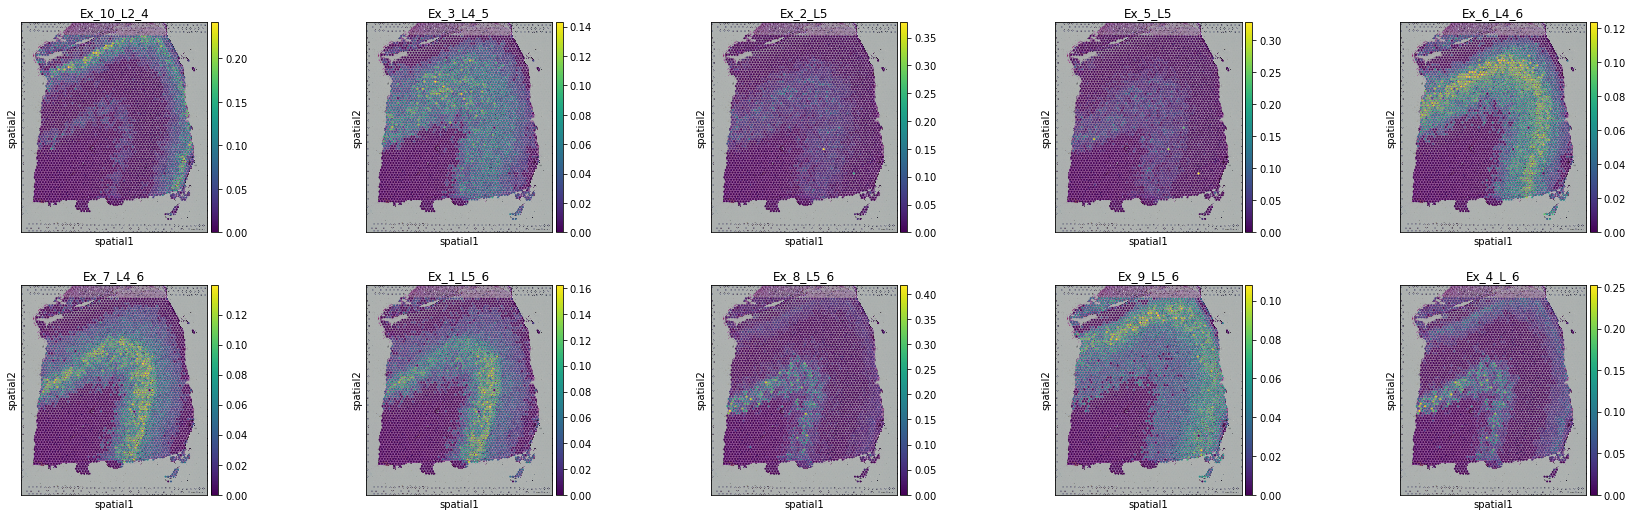

In [4]:
ex_types=['Ex_10_L2_4', 'Ex_3_L4_5', 'Ex_2_L5', 'Ex_5_L5', 'Ex_6_L4_6', 'Ex_7_L4_6', 'Ex_1_L5_6', 'Ex_8_L5_6', 'Ex_9_L5_6', 'Ex_4_L_6']
st.obs[ex_types] = scle_pred[ex_types]
sc.pl.spatial(st, img_key='hires', color=ex_types, show=True, ncols=5, wspace = 0)